Mulai merekam selama 10s…
Tersimpan: original_audio.wav
Tersimpan: noisy_audio.wav
Tersimpan: filtered_audio.wav


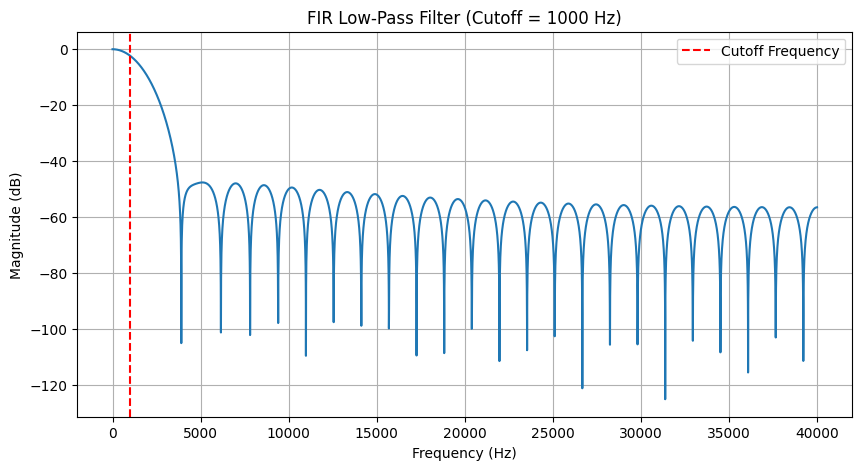

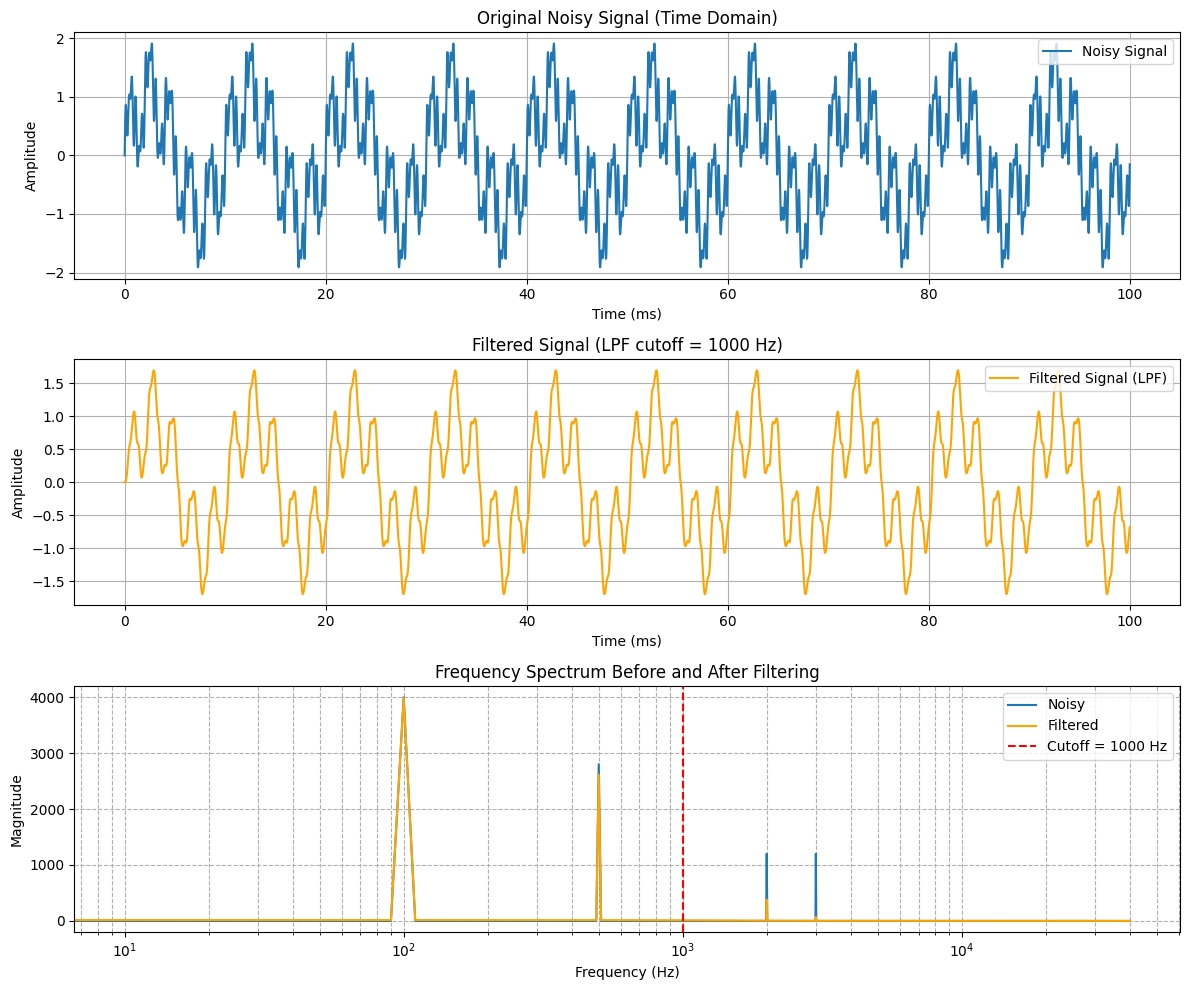

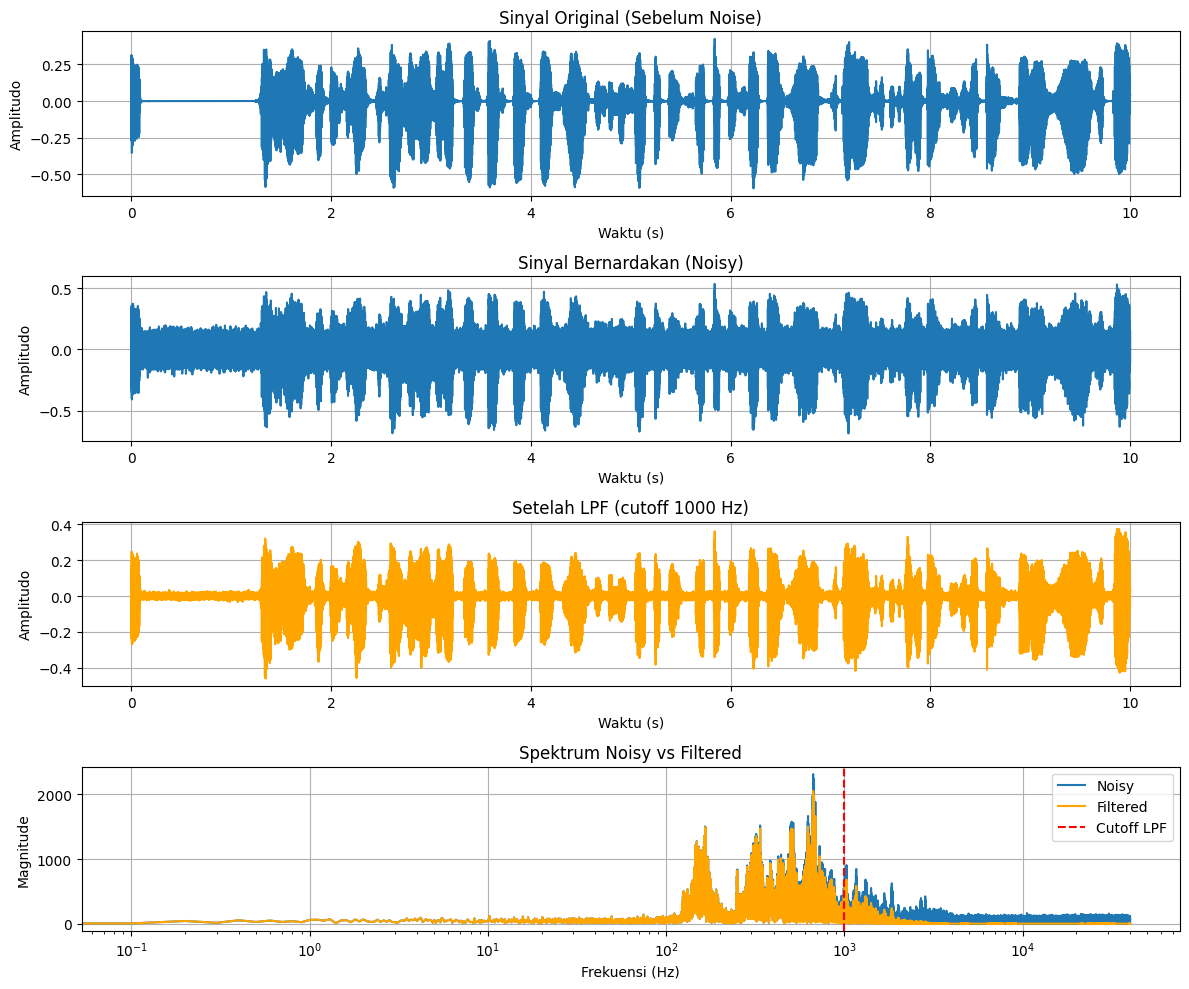

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter
from scipy.io import wavfile
import sounddevice as sd
import os

# — Parameters —
fs        = 44100     # Sampling rate (Hz)
duration  = 10        # Recording duration (s)
noise_amp = 0.05      # Noise amplitude

fc        = 1000      # Cutoff frequency (Hz)
N         = 50        # Filter order
numtaps   = N + 1     # Total number of taps

original_file = "original_audio.wav"
noisy_file    = "noisy_audio.wav"
filtered_file = "filtered_audio.wav"

# — Record if needed —
if not os.path.exists(original_file):
    print(f"Mulai merekam selama {duration}s…")
    rec = sd.rec(int(duration * fs),
                 samplerate=fs,
                 channels=1,
                 dtype='float32')
    sd.wait()
    wavfile.write(original_file,
                  fs,
                  (rec.flatten() * np.iinfo(np.int16).max).astype(np.int16))
    print(f"Tersimpan: {original_file}")
else:
    print(f"Menggunakan file: {original_file}")

# — Read & normalize —
_, data_int = wavfile.read(original_file)
data = data_int.astype(np.float32) / np.iinfo(np.int16).max

# — Add noise & save —
noisy = data + noise_amp * np.random.randn(len(data))
wavfile.write(noisy_file,
              fs,
              (noisy * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {noisy_file}")

# — FIR LPF design (Hamming) —
cutoff    = fc / (fs / 2)
fir_coeff = firwin(numtaps, cutoff=cutoff, window='hamming')

# — Apply LPF & save —
filtered = lfilter(fir_coeff, 1.0, noisy)
wavfile.write(filtered_file,
              fs,
              (filtered * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {filtered_file}")

# — Plot frequency response —
w, h = freqz(fir_coeff, worN=8000)
frequencies = w * fs / (2 * np.pi)

plt.figure(figsize=(10, 5))
plt.plot(frequencies, 20 * np.log10(np.abs(h)))
plt.title(f'FIR Low-Pass Filter (Cutoff = {fc} Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.axvline(fc, color='red', linestyle='--', label='Cutoff Frequency')
plt.legend()
plt.show()

# — Simulated time-series & filtering —
T = 0.1
t = np.arange(0, T, 1/fs)

f1 = 100
f2 = 500
f3 = 2000
f4 = 3000

x = (np.sin(2*np.pi*f1*t) +
     0.7*np.sin(2*np.pi*f2*t) +
     0.3*np.sin(2*np.pi*f3*t) +
     0.3*np.sin(2*np.pi*f4*t))

y = lfilter(fir_coeff, 1.0, x)

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t*1e3, x, label='Noisy Signal')
plt.title('Original Noisy Signal (Time Domain)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t*1e3, y, label='Filtered Signal (LPF)', color='orange')
plt.title(f'Filtered Signal (LPF cutoff = {fc} Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
f_axis = np.fft.rfftfreq(len(t), 1/fs)
fft_x      = np.abs(np.fft.rfft(x))
fft_y      = np.abs(np.fft.rfft(y))
plt.semilogx(f_axis, fft_x, label='Noisy')
plt.semilogx(f_axis, fft_y, label='Filtered', color='orange')
plt.title('Frequency Spectrum Before and After Filtering')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(which='both', linestyle='--')
plt.axvline(fc, color='red', linestyle='--', label=f'Cutoff = {fc} Hz')
plt.legend()

plt.tight_layout()
plt.show()

# — Plot Sinyal (Time & Spectrum) —
t2     = np.arange(len(data)) / fs
f_axis2 = np.fft.rfftfreq(len(t2), 1/fs)

plt.figure(figsize=(12, 10))

plt.subplot(4,1,1)
plt.plot(t2, data)
plt.title('Sinyal Original (Sebelum Noise)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t2, noisy)
plt.title('Sinyal Bernardakan (Noisy)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t2, filtered, color='orange')
plt.title(f'Setelah LPF (cutoff {fc} Hz)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(4,1,4)
plt.semilogx(f_axis2, np.abs(np.fft.rfft(noisy)),    label='Noisy')
plt.semilogx(f_axis2, np.abs(np.fft.rfft(filtered)), label='Filtered', color='orange')
plt.axvline(fc, color='red', linestyle='--', label='Cutoff LPF')
plt.title('Spektrum Noisy vs Filtered')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
